# Milestone Project 1: Food Vision Big

See the annotated version (plenty of text and explanations for each part) of this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

And see the full course materials (including exercises and extra-curriculum) on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/

In [1]:
import tf_keras as keras

## Check GPU

Google Colab offers free GPUs (thank you Google), however, not all of them are compatiable with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

📖 **Resource:** You can read more about the benefits of mixed precision training in the TensorFlow Mixed Precision documentation: https://www.tensorflow.org/guide/mixed_precision


In [2]:
# If the following line doesn't output "Tesla T4", you can try getting access to
# another GPU by going to Runtime -> Factory Reset Runtime -> "Yes" and then
# re-running this cell.
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d7c1fc4a-1e5d-b359-6d7d-f5f8ebe83d26)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
# Download helper functions script
!wget https://raw.githubusercontent.com/sercanxs/Notes/refs/heads/master/Notes/TensorFlow/Extra/helper_functions.py

--2025-02-26 13:10:04--  https://raw.githubusercontent.com/sercanxs/Notes/refs/heads/master/Notes/TensorFlow/Extra/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10268 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.03K  --.-KB/s    in 0s      

2025-02-26 13:10:04 (77.3 MB/s) - ‘helper_functions.py’ saved [10268/10268]



In [4]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [5]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [6]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


🛠 **Exercise:** Running the following cell can take a while using Google Colab (about 5-6 minutes). While your data is downloading, have a read through the TensorFlow Datasets documentation: https://www.tensorflow.org/datasets/overview

🔑 **Note:** Some of the datasets contained within TensorFlow datasets are over 100GB+, meaning if you run the cell below (outside of Google Colab), you might be downloading 100GB+ to your computer or the computer that you're using. Beware as this could take a large amount of bandwidth.

In [7]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"], # splits can be a little tricky, for more see: https://www.tensorflow.org/datasets/splits
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.05731C_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.05731C_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [8]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [11]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (384, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


In [13]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [144,  81, 102],
        [142,  78, 102],
        [139,  75,  99]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [159,  96, 115],
        [154,  89, 111],
        [146,  83, 104]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [162,  98, 114],
        [162,  95, 113],
        [157,  93, 110]],

       ...,

       [[ 75,  32,  16],
        [ 77,  34,  17],
        [ 78,  35,  19],
        ...,
        [ 99,  31,  20],
        [104,  32,  20],
        [106,  34,  20]],

       [[ 81,  34,  18],
        [ 81,  34,  16],
        [ 82,  35,  19],
        ...,
        [102,  33,  26],
        [104,  36,  27],
        [109,  39,  31]],

       [[ 79,  30,  13],
        [ 80,  31,  14],
        [ 81,  32,  15],
        ...,
        [113,  46,  4

In [14]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

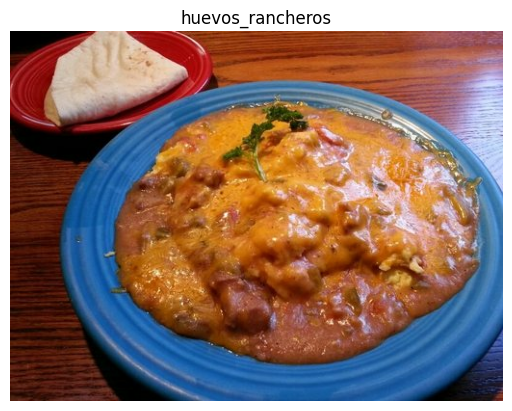

In [15]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is assosciated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `unit8` to `float32`

In [16]:
# Our data comes in the tuple structure: (image, label)

In [17]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (not required with EfficientNetBX models from keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [18]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [144  81 102]
  [142  78 102]
  [139  75  99]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [159  96 115]
  [154  89 111]
  [146  83 104]]]..., 
Shape: (384, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  ...
  [157.23973   91.24997  110.18368 ]
  [150.2857    86.622444 107.239784]
  [144.57637   80.47435  103.6325  ]]

 [[  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  ...
  [157.85226   91.70941  105.097206]
  [164.45404   97.72448  114.3112  ]
  [159.09677   93.16319  110.545815]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


In [20]:
print(f"{image[:2].shape}, \nShape: {image.shape},\nDatatype: {image.dtype}\n")

(2, 512, 3), 
Shape: (384, 512, 3),
Datatype: <dtype: 'uint8'>



## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly going through the following guide: https://www.tensorflow.org/guide/data_performance

In [21]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch."

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [23]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [24]:
# Turn on mixed precision training
from tf_keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [25]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [27]:
from tf_keras import layers
from tf_keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

24274472/24274472 [==============================] - 0s 0us/step


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype policies (are we using mixed precision?)

In [29]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [30]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Po

In [31]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [32]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20250226-133228
Epoch 1/3
2368/2368 [==============================] - 183s 71ms/step - loss: 1.7455 - accuracy: 0.5780 - val_loss: 1.1422 - val_accuracy: 0.7037
Epoch 2/3
2368/2368 [==============================] - 171s 71ms/step - loss: 1.2107 - accuracy: 0.6859 - val_loss: 1.0402 - val_accuracy: 0.7211
Epoch 3/3
2368/2368 [==============================] - 169s 70ms/step - loss: 1.0636 - accuracy: 0.7227 - val_loss: 1.0015 - val_accuracy: 0.7307


In [33]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 48s 61ms/step - loss: 0.9982 - accuracy: 0.7290


[0.9981707334518433, 0.7289900779724121]

## Off to you...

We've covered a lot of ground so far but since this is a milestone project, it's time for you to takeover.

More specifically, you're challenge is to complete the TEMPLATE version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper.

In other words, you're going to create Food Vision Big!!!

You can find the TEMPLATE notebook here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb

And if you get stuck, you can refer to the example version (non-template): https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb